In [42]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [43]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/TRIO_data/')

Try loading a niFti dataset of a single patient (single scan)

In [44]:
os.chdir('./Subj10Scan1/')

In [45]:
img = nib.load("NODDI_3Shells.nii.gz")
data = img.get_data()

In [46]:
#get the dimestions of the dataset
print(data.shape)

(96, 96, 55, 117)


In [47]:
#get the size/dimensions of each voxel
print(img.header.get_zooms()[:3])

(2.5, 2.5, 2.5)


Try visualizing the dataset using matplotlib. For example, let’s show the middle axial slices of volume 0 and volume 10.

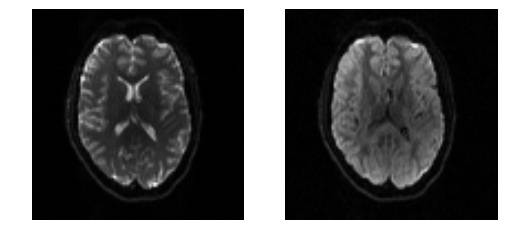

In [48]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

Try visualising the data at the intersection of a voxel e.g (x=40,y=40,z=20)

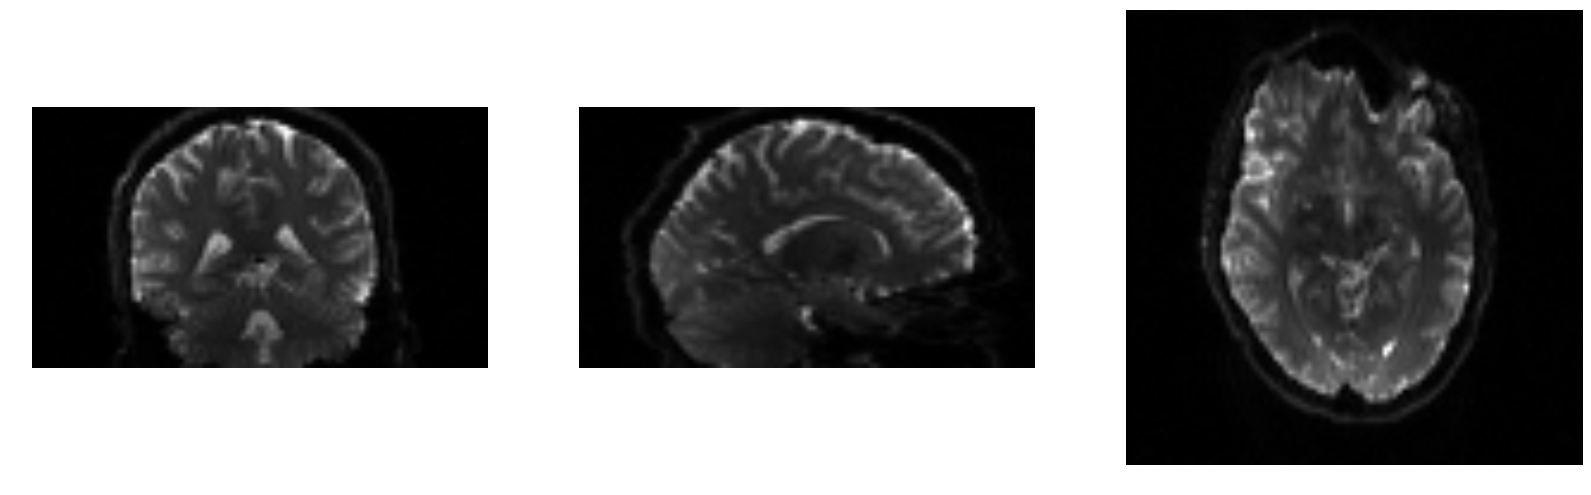

In [49]:
plt.figure
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data[:, 40, :, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(data[40, :, :, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(data[:, :, 20, 0].T, cmap='gray', origin='lower')
plt.show()


Next load Bval and Bvec files

In [50]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

Use a GradientTable object to hold all the acquisition specific parameters, e.g. b-values, b-vectors. Use function gradient_table to create the object.

In [51]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [52]:
print(gtab.info)

B-values shape (117,)
         min 5.000000 
         max 2000.000000 
B-vectors shape (117, 3)
         min -0.997205 
         max 0.999862 
None


In [53]:
print(gtab.bvals)

[    5.   700.   700.   700.   700.   700.   700.   700.   700.     5.
   700.   700.   700.   700.   700.   700.   700.   700.     5.   700.
   700.   700.   700.   700.   700.   700.   700.     5.   700.   700.
   700.   700.   700.   700.   700.   700.     5.  2000.  2000.  2000.
  2000.  2000.  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.
  2000.  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.
  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.
  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.
  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.
     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.     5.
  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.     5.   300.
   300.   300.   300.   300.   300.   300.   300.]


In [54]:
#print the first 10 bvectors (notation is the same as matlib matrix indexing)
print(gtab.bvecs[:10, :])

[[-0.5773502  -0.56513256  0.58931476]
 [ 0.51869565  0.85274225 -0.06152632]
 [ 0.80059832 -0.0819406  -0.59357226]
 [ 0.51508027  0.71643335 -0.47054818]
 [ 0.11831205  0.96070033 -0.25111184]
 [-0.46743399 -0.56365108 -0.68103075]
 [ 0.71663481  0.21114066  0.66472107]
 [ 0.5994221  -0.50575012 -0.62041116]
 [-0.8000164   0.21150333 -0.56146246]
 [-0.5773502  -0.56513256  0.58931476]]


In [64]:
#another way to get the shape of numpy arrays
gtab.bvecs.shape

(117, 3)

AttributeError: 'GradientTable' object has no attribute 'b5s_mask'